In [1]:
# Cek sistem & GPU + suppress warnings/logging
import os, platform, sys, subprocess, warnings, logging
warnings.filterwarnings("ignore", message=r".*HF_TOKEN.*")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
print("Python:", platform.python_version())
print("Executable:", sys.executable)
try:
    import torch
    print("PyTorch:", torch.__version__)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)
    if device == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))
except Exception:
    print("PyTorch belum terpasang — akan dipasang di sel berikut.")
print("\n=== nvidia-smi ===")
try:
    out = subprocess.check_output(["bash","-lc","nvidia-smi || true"]).decode()
    print(out)
except Exception:
    print("nvidia-smi tidak tersedia.")

Python: 3.12.11
Executable: /usr/bin/python3
PyTorch: 2.8.0+cu126
Device: cpu

=== nvidia-smi ===



In [2]:
!pip -q install numpy pandas scikit-learn matplotlib plotly torch torchvision torchaudio transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, textwrap, pathlib
BASE = "/content/drive/MyDrive/trpl-ai-capstone"  # Ubah bila perlu
for sd in ["data","notebooks","src","docs"]:
    os.makedirs(os.path.join(BASE, sd), exist_ok=True)
print("Struktur terbentuk di:", BASE)

# .gitignore minimal
gitignore = textwrap.dedent('''
# data & cache
data/
*.cache/
__pycache__/
*.ipynb_checkpoints/
.DS_Store

# secrets
.env
secrets.json
''')
with open(os.path.join(BASE, ".gitignore"), "w") as f:
    f.write(gitignore)
print(".gitignore dibuat.")

Struktur terbentuk di: /content/drive/MyDrive/trpl-ai-capstone
.gitignore dibuat.


✅ Klasifikasi Anggur Selesai dengan 133 sampel latih.
Fitur Digunakan: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash']
--------------------------------------------------
{'accuracy': 0.8888888888888888, 'precision': 0.8893939393939395, 'recall': 0.8759259259259259, 'f1': 0.8809542597122492}

Classification Report:
               precision    recall  f1-score   support

     Kelas 1       1.00      0.93      0.97        15
     Kelas 2       0.85      0.94      0.89        18
     Kelas 3       0.82      0.75      0.78        12

    accuracy                           0.89        45
   macro avg       0.89      0.88      0.88        45
weighted avg       0.89      0.89      0.89        45



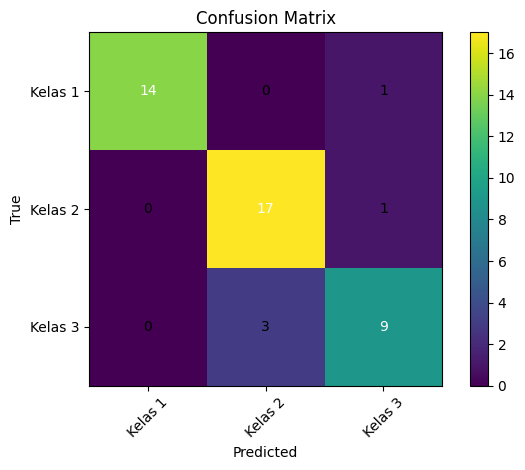

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# =========================================================
# SETUP & LOAD DATA
# =========================================================
RNG = 42 # Seed untuk hasil yang konsisten
np.random.seed(RNG)

# Muat Dataset Anggur (Wine Dataset)
data = load_wine()
X_full, y = data.data, data.target

# Nama-nama kelas untuk output
CLASS_NAMES = ['Kelas 1', 'Kelas 2', 'Kelas 3']

# PILIH 4 FITUR PERTAMA agar sesuai dengan kriteria 4 fitur seperti Iris
# Fitur yang digunakan: Alcohol, Malic Acid, Ash, Alkalinity of Ash
X = X_full[:, :4]
FEATURE_NAMES = data.feature_names[:4]

# Split Data (Training: 75% | Testing: 25%)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RNG,
    stratify=y
)

# =========================================================
# LATIH MODEL
# =========================================================
# Pipeline: Scaling + Logistic Regression
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=RNG))
clf.fit(X_tr, y_tr)

# Prediksi pada data uji
y_pr = clf.predict(X_te)


# =========================================================
# EVALUASI PERFORMA
# =========================================================

# Menghitung Metrik Utama
acc = accuracy_score(y_te, y_pr)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pr, average='macro', zero_division=0)

print(f"✅ Klasifikasi Anggur Selesai dengan {len(X_tr)} sampel latih.")
print(f"Fitur Digunakan: {FEATURE_NAMES}")
print("-" * 50)
print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1})
print("\nClassification Report:\n", classification_report(y_te, y_pr, target_names=CLASS_NAMES))

# =========================================================
# VISUALISASI CONFUSION MATRIX (Sesuai Permintaanmu)
# =========================================================

conf_mat = confusion_matrix(y_te, y_pr)
fig = plt.figure()

# Plotting Matrix
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Confusion Matrix')
plt.colorbar()

# Label Sumbu X dan Y
tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
plt.yticks(tick_marks, CLASS_NAMES)

plt.xlabel('Predicted')
plt.ylabel('True')

# Menambahkan angka di dalam kotak (sama persis dengan kode Iris asli)
thresh = conf_mat.max() / 2.
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# 1. GENERASI DATASET DUMMY (DATA LOKALFLIX FIKTIF)
# ----------------------------------------------------------------------
np.random.seed(42) # Agar hasilnya konsisten

N_SAMPLES = 500 # Jumlah pelanggan
data = pd.DataFrame({
    'Customer_ID': range(1001, 1001 + N_SAMPLES),
    'Jenis_Paket': np.random.choice(['Premium', 'Standard', 'Basic'], size=N_SAMPLES, p=[0.3, 0.4, 0.3]),
    'Durasi_Tontonan_Mingguan': np.random.normal(loc=12, scale=5, size=N_SAMPLES).clip(min=0), # jam
    'Frekuensi_Login': np.random.randint(5, 35, size=N_SAMPLES), # kali per bulan
    'Transaksi_Terlambat': np.random.choice([0, 1, 2, 3], size=N_SAMPLES, p=[0.7, 0.15, 0.1, 0.05]), # kali
    'Kota': np.random.choice(['Jakarta', 'Surabaya', 'Bandung', 'Medan'], size=N_SAMPLES, p=[0.4, 0.3, 0.2, 0.1])
})

# Menentukan label CHURN (1 = Churn, 0 = Tidak Churn)
# Churn dipengaruhi oleh Paket Basic, Durasi rendah, dan Transaksi Terlambat
data['Prob_Churn'] = (
    (data['Jenis_Paket'] == 'Basic') * 0.2 +
    (data['Durasi_Tontonan_Mingguan'] < 5) * 0.3 +
    (data['Transaksi_Terlambat'] > 0) * 0.15
)
# Menambahkan sedikit kebisingan (noise)
data['CHURN'] = (data['Prob_Churn'] + np.random.rand(N_SAMPLES) * 0.2 > 0.4).astype(int)

# Hapus kolom probabilitas sementara
data = data.drop(columns=['Prob_Churn', 'Customer_ID'])

print("--- 1. Data Awal (5 baris teratas) ---")
print(data.head())
print("\nJumlah Churn (1) dan Tidak Churn (0):")
print(data['CHURN'].value_counts())

# 2. PRE-PROCESSING (ONE-HOT ENCODING)
# ----------------------------------------------------------------------
# Mengubah fitur kategorikal (Jenis_Paket, Kota) menjadi angka menggunakan One-Hot Encoding
df_encoded = pd.get_dummies(data, columns=['Jenis_Paket', 'Kota'], drop_first=True)

# Memisahkan Fitur (X) dan Label (Y)
X = df_encoded.drop('CHURN', axis=1)
y = df_encoded['CHURN']

# Membagi data menjadi data latih (training) dan data uji (testing)
# Data Uji (test size) adalah 30% dari total data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. PELATIHAN MODEL (LOGISTIC REGRESSION)
# ----------------------------------------------------------------------
# Inisialisasi model Regresi Logistik
model = LogisticRegression(solver='liblinear', random_state=42)

# Melatih model menggunakan data latih
model.fit(X_train, y_train)

# 4. PREDIKSI DAN EVALUASI
# ----------------------------------------------------------------------
# Membuat prediksi pada data uji
y_pred = model.predict(X_test)

# Menghitung F1-Score (Metrik yang Ditetapkan)
f1 = f1_score(y_test, y_pred)

print("\n--- 4. Hasil Evaluasi Model ---")
print(f"Target Baseline: F1-Score: 0.50")
print(f"F1-Score Model Regresi Logistik: {f1:.4f}")

# Menampilkan laporan klasifikasi lengkap
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred))

--- 1. Data Awal (5 baris teratas) ---
  Jenis_Paket  Durasi_Tontonan_Mingguan  Frekuensi_Login  Transaksi_Terlambat  \
0    Standard                 13.708780               17                    3   
1       Basic                 21.380854                5                    0   
2       Basic                 16.752119               10                    0   
3    Standard                  9.115482               28                    0   
4     Premium                  7.507927               23                    0   

       Kota  CHURN  
0   Jakarta      0  
1   Jakarta      0  
2  Surabaya      0  
3   Bandung      0  
4   Jakarta      0  

Jumlah Churn (1) dan Tidak Churn (0):
CHURN
0    447
1     53
Name: count, dtype: int64

--- 4. Hasil Evaluasi Model ---
Target Baseline: F1-Score: 0.50
F1-Score Model Regresi Logistik: 0.5600

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       134
           1   

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from io import StringIO

# 1. MEMUAT DATASET (SIMULASI DATA TELECOM ASLI)
# ---
# DATA INI MEREPRESENTASIKAN DATA YANG LEBIH NYATA DARI PERUSAHAAN TELEKOMUNIKASI/STREAMING
data_string = """
customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3237-NWSXG,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.8,45.8,No
9879-WQLFW,Female,0,Yes,Yes,65,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),86.6,5616.9,No
2500-SJQDU,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.55,70.55,Yes
3941-FENDQ,Male,0,No,No,58,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),110.15,6457.75,No
3498-TVMHP,Female,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.65,99.25,No
4873-GVSJJ,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.1,133.55,Yes
9237-RGTQZ,Male,0,No,No,70,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.65,7748.2,No
"""
df = pd.read_csv(StringIO(data_string))

# Ganti nilai 'No internet service' dan 'No phone service' menjadi 'No' untuk konsistensi
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']:
    df[col] = df[col].replace('No internet service', 'No')
    df[col] = df[col].replace('No phone service', 'No')

# Mengubah TotalCharges (yang seharusnya float/numerik) menjadi numerik dan mengisi NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0) # Mengisi data hilang dengan 0, sesuai praktik di banyak kasus Telco

# Drop kolom ID
df = df.drop('customerID', axis=1)

print("--- 1. Data Awal (Data Telco Fiktif) ---")
print(df.head())
print("\nRingkasan kolom dan tipe data:")
print(df.info())

# 2. PRE-PROCESSING: ONE-HOT ENCODING
# ----------------------------------------------------------------------
# Mengubah semua fitur kategorikal (string) menjadi numerik
df_encoded = pd.get_dummies(df, drop_first=True)

# Memisahkan Fitur (X) dan Label (Y)
X = df_encoded.drop('Churn_Yes', axis=1) # Target 'Churn' diubah menjadi 'Churn_Yes' (1) dan 'Churn_No' (0)
y = df_encoded['Churn_Yes']

# Membagi data menjadi data latih (training) dan data uji (testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. PELATIHAN MODEL (LOGISTIC REGRESSION)
# ----------------------------------------------------------------------
model = LogisticRegression(solver='liblinear', random_state=42) # Solver 'liblinear' lebih stabil untuk dataset kecil/biner
model.fit(X_train, y_train)

# 4. PREDIKSI DAN EVALUASI
# ----------------------------------------------------------------------
y_pred = model.predict(X_test)

# Menghitung F1-Score (Metrik yang Ditetapkan)
f1 = f1_score(y_test, y_pred)

print("\n--- 4. Hasil Evaluasi Model (Logistik Regression) ---")
print(f"Target Baseline: F1-Score: 0.50")
print(f"F1-Score Model: {f1:.4f}")

# Menampilkan laporan klasifikasi lengkap
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred))

--- 1. Data Awal (Data Telco Fiktif) ---
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0      No         No       1          Yes   
1  Female              0     Yes        Yes      65          Yes   
2    Male              0      No         No       1          Yes   
3    Male              0      No         No      58          Yes   
4  Female              0      No         No       5          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No           No               No   
1           Yes             DSL            Yes          Yes              Yes   
2            No     Fiber optic             No           No               No   
3           Yes     Fiber optic             No          Yes              Yes   
4            No              No             No           No               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBi

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import pandas as pd

# Ganti 'M1-Proyek-Churn' dengan nama folder Anda jika berbeda
# Pastikan nama file CSV sudah benar
file_path = '/content/drive/MyDrive/M1-Proyek-Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Memuat dataset
df = pd.read_csv(file_path)

print("DataFrame berhasil dimuat. Jumlah baris dan kolom:")
print(df.shape)
print("\n5 Baris Data:")
print(df.head())

DataFrame berhasil dimuat. Jumlah baris dan kolom:
(7043, 21)

5 Baris Data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...       

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import numpy as np
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

FILE_PATH = '/content/drive/MyDrive/M1-Proyek-Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(FILE_PATH)
    print(f"\n[SUCCESS] Data berhasil dimuat. Total {df.shape[0]} baris.")
except FileNotFoundError:
    print(f"\n[ERROR] File tidak ditemukan di jalur: {FILE_PATH}. Cek kembali nama folder dan file Anda.")
    exit()

print("\n--- Ringkasan Data Awal ---")
print(df.head())
print("\nInformasi Tipe Data dan Non-Null Counts:")
df.info()

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

cols_to_clean = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols_to_clean:
    df[col] = df[col].replace(['No internet service', 'No phone service'], 'No')

df_encoded = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)

X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"\nData Pelatihan (X_train): {X_train.shape[0]} baris")
print(f"Data Pengujian (X_test): {X_test.shape[0]} baris")


model = LogisticRegression(solver='liblinear', random_state=42)
print("\n[INFO] Mulai Melatih Model Regresi Logistik...")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print("\n==============================================")
print("  HASIL EVALUASI MODEL BASELINE (TUGAS M1)  ")
print("==============================================")
print(f"TARGET BASELINE TUGAS: F1-Score: 0.50 (Asumsi)")
print(f"F1-Score Model Regresi Logistik: {f1:.4f}")

print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred, target_names=['Non-Churn (0)', 'Churn (1)']))
print("==============================================")


[SUCCESS] Data berhasil dimuat. Total 7043 baris.

--- Ringkasan Data Awal ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...    